In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib

from tqdm import tqdm

In [3]:
path = '../data/clusters/'
path_data = "../data/"

feature_name = 'feature_set_'
path_features = path+feature_name

inherent_name = 'inherent.csv'
non_nodal_name = 'non_nodal.csv'
feature_list = 'feature_list.csv'

In [4]:
measures = ['t1', 't2', 'degree_centrality', 'strength', 'incloseness', 'authorities', 
            'k_out', 'k_in', 'average_controllability', 'betweenness_centrality', ]

In [5]:
topics = ['ukraine', 'covid', 'costofliving', 'brexit']

In [6]:
master = pd.read_csv(path+'common_nodes_count.csv')
master['share'] = master.no_of_common_nodes/master.min_size
master = master.reset_index().rename(columns={'index': 'id'})
master.id += 1

In [9]:
def get_list_features(best, measures, id_):
    l = best.loc[best.id==id_, 'features'].values[0]
    list_ = list()
    for measure in measures:
        if measure in l:
            list_.append(measure)
    return list_

def get_lists_of_list_features(best, measures):
    list_of_lists = list()
    for id_ in best.id.values:
        list_ = get_list_features(best, measures, id_)
        list_of_lists.append(list_)
    return list_of_lists


def transform_common_nodes_to_list(best):
    list_of_lists = list()
    for id_ in best.id.values:
        string = best.loc[best.id==id_, 'common_nodes'].values[0]
        l = string.split("'")[1::2]
        len_ = best.loc[best.id==id_, 'no_of_common_nodes'].values[0]
        if (type(l) == list) and (len(l)==len_):
            list_of_lists.append(l)
        else:
            list_of_lists.append(string)
    best['common_nodes'] = list_of_lists

    return best

def get_second_group(best):
    column_name = 'second_common_nodes'
    list_of_lists = list()
    cardinalities = list()
    if column_name not in best.columns:
        for id_ in best.id.values:
            nodes = pd.read_csv(path+feature_name+str(id_)+'/'+non_nodal_name)['0'].to_list()
            len_nodes = len(nodes)
            other_nodes = best.loc[best.id==id_, 'common_nodes'].values
            if (nodes[0] in other_nodes):
                nodes = pd.read_csv(path+feature_name+str(id_)+'/'+inherent_name)['0'].to_list()
                len_nodes = len(nodes)
                
            list_of_lists.append(nodes)
            cardinalities.append(len_nodes)
            
        best[column_name] = list_of_lists
        best['no_of_'+column_name] = cardinalities
        
        return best
    else:
        print('second group of common nodes is already in best DataFrame')
        return best
    
def are_features_the_same_test(best):
    are_the_same = list()

    for id_ in best.id.values:
        df = pd.read_csv(path_features+str(id_)+'/'+feature_list, index_col=0).rename(columns={'0': 'features'})
        df = df.loc[:len(df)/2-1, 'features'].values

        list_ = np.array(best.loc[best.id==id_, 'features'].values[0])

        b = bool(np.floor(sum(np.equal(np.sort(list_),np.sort(df)))/len(df)))
        are_the_same.append(b)

    are_they = bool(np.floor(sum(are_the_same)))
    return are_they

def get_df_counts(best, measures):

    counts = np.zeros(len(measures))
    for list_ in best.features.values:
        for (i, measure) in enumerate(measures):
            if measure in list_:
                counts[i] += 1
    df_counts = pd.DataFrame()
    df_counts['measures'] = measures
    df_counts['counts'] = counts

    return df_counts

def get_mi_diff_pop_1(X,Y,niter=100):
    N,T = np.shape(X)
    M,_ = np.shape(Y)

    te_xy = []

    for z in range(niter):
        selected_idx = np.random.choice(M,size = N,replace=False)
        y = Y[selected_idx]
        xy_temp = []

        for i in range(1,T):
            txy = get_cmi(X[:,i-1],y[:,i],y[:,i-1])
            xy_temp.append(txy)
        te_xy.append(xy_temp)
    te_xy = np.mean(te_xy,axis=0)
    return te_xy


def get_share_H_Y(l_x, l_y, timeseries_weekly):
    X = timeseries_weekly.loc[timeseries_weekly.Screen_name.isin(l_x), timeseries_weekly.columns[1:]].values
    Y = timeseries_weekly.loc[timeseries_weekly.Screen_name.isin(l_y), timeseries_weekly.columns[1:]].values

    te_xy = get_mi_diff_pop_1(X, Y)

    H_Y = np.array([H(Y[:, i]) for i in range(Y.shape[1])])
    share_H_Y = [100*te_xy[i]/H_Y[i+1] if (te_xy[i]!=0) and (H_Y[i+1]!=0) else 0 for i in range(len(te_xy))]
    share_H_Y = np.array(share_H_Y)
    
    return share_H_Y

def get_share_H_exclusive(l_x, timeseries_weekly):
    X = timeseries_weekly.loc[timeseries_weekly.Screen_name.isin(l_x), timeseries_weekly.columns[1:]].values
    Y = timeseries_weekly.loc[~timeseries_weekly.Screen_name.isin(l_x), timeseries_weekly.columns[1:]].values

    te_xy, te_yx = get_mi_diff_pop(X, Y)
    
    H_X = np.array([H(X[:, i]) for i in range(X.shape[1])])
    share_H_X = [100*te_yx[i]/H_X[i+1] if (te_yx[i]!=0) and (H_X[i+1]!=0) else 0 for i in range(len(te_yx))]
    share_H_X = np.array(share_H_X)

    H_Y = np.array([H(Y[:, i]) for i in range(Y.shape[1])])
    share_H_Y = [100*te_xy[i]/H_Y[i+1] if (te_xy[i]!=0) and (H_Y[i+1]!=0) else 0 for i in range(len(te_xy))]
    share_H_Y = np.array(share_H_Y)
    
    return share_H_X, share_H_Y

def get_TEs(l_x, timeseries_weekly):
    X = timeseries_weekly.loc[timeseries_weekly.Screen_name.isin(l_x), timeseries_weekly.columns[1:]].values
    Y = timeseries_weekly.loc[~timeseries_weekly.Screen_name.isin(l_x), timeseries_weekly.columns[1:]].values

    te_xy, te_yx = get_mi_diff_pop(X, Y)
    
    return te_yx, te_xy

def get_all_active_nodes(combinations_to_try):
    active_nodes = pd.DataFrame()

    for id_ in combinations_to_try.id.values:
        inherent = combinations_to_try.loc[combinations_to_try.id==id_, 'inherent'].values[0]
        non_nodal = combinations_to_try.loc[combinations_to_try.id==id_, 'non_nodal'].values[0]

        for topic in topics:
            for cluster in range(3):
                list_topic = pd.read_csv(path+feature_name+f'{id_}/{topic}_{cluster}.csv').Node.to_list()

                len_inter_inherent = len(set(inherent).intersection(set(list_topic)))
                len_inter_non_nodal = len(set(non_nodal).intersection(set(list_topic)))

                if (len_inter_non_nodal == 0) and (len_inter_inherent == 0):
                    active_nodes[f'{topic}_{id_}'] = [list_topic]
                    active_nodes[f'len_{topic}_{id_}'] = len(list_topic)
    return active_nodes

def get_three_clusters(id_, combinations_to_try):
    three_clusters = pd.DataFrame()
    
    inherent = combinations_to_try.loc[combinations_to_try.id==id_, 'inherent'].values[0]
    non_nodal = combinations_to_try.loc[combinations_to_try.id==id_, 'non_nodal'].values[0]
    
    for topic in topics:
        for cluster in range(3):
            list_topic = pd.read_csv(path+feature_name+f'{id_}/{topic}_{cluster}.csv').Node.to_list()

            len_inter_inherent = len(set(inherent).intersection(set(list_topic)))
            len_inter_non_nodal = len(set(non_nodal).intersection(set(list_topic)))
            
            if (len_inter_non_nodal == 0) and (len_inter_inherent == 0):
                three_clusters[f'{topic}_active'] = [list_topic]
            elif len_inter_inherent != 0:
                three_clusters[f'{topic}_inherent'] = [list_topic]
            elif len_inter_non_nodal != 0:
                three_clusters[f'{topic}_non_nodal'] = [list_topic]
    return three_clusters

def get_four_clusters(id_, combinations_to_try):
    four_clusters = pd.DataFrame()
    
    inherent = combinations_to_try.loc[combinations_to_try.id==id_, 'inherent'].values[0]
    non_nodal = combinations_to_try.loc[combinations_to_try.id==id_, 'non_nodal'].values[0]
    
    four_clusters['inherent'] = [inherent]
    
    for topic in topics:
        for cluster in range(3):
            list_topic = pd.read_csv(path+feature_name+f'{id_}/{topic}_{cluster}.csv').Node.to_list()
            
            len_inter_inherent = len(set(inherent).intersection(set(list_topic)))
            len_inter_non_nodal = len(set(non_nodal).intersection(set(list_topic)))
            
            if (len_inter_non_nodal == 0) and (len_inter_inherent == 0):
                four_clusters[f'{topic}_funnel'] = [list_topic]
            elif len_inter_inherent != 0:
                four_clusters[f'{topic}_active'] = [[node for node in list_topic if node not in inherent]]
            elif len_inter_non_nodal != 0:
                four_clusters[f'{topic}_non_nodal'] = [list_topic]
    return four_clusters

In [7]:
from helper_functions import *

In [10]:
best = master.sort_values(by='share', ascending=False).reset_index(drop=True).loc[:7, :] #:7
list_of_lists = get_lists_of_list_features(best, measures)
best['features'] = list_of_lists
best = transform_common_nodes_to_list(best)
best = get_second_group(best)
best['no_of_total_common_nodes'] = best['no_of_common_nodes']+best['no_of_second_common_nodes']

best_ids = best.id.values

In [11]:
best = best.sort_values(by='no_of_total_common_nodes', ascending=False).reset_index(drop=True).loc[:, :]
best_ids = best.id.values

In [12]:
are_features_the_same_test(best)

True

In [13]:
df_counts = get_df_counts(best, measures)
df_counts.sort_values(by='counts', ascending=False)

,measures,counts
0,t1,8.0
5,authorities,5.0
2,degree_centrality,4.0
3,strength,4.0
4,incloseness,3.0
7,k_in,3.0
6,k_out,1.0
8,average_controllability,1.0
1,t2,0.0
9,betweenness_centrality,0.0


In [14]:
num_to_try = 1

combinations_to_try = pd.DataFrame()
combinations_to_try['id'] = best.id.values[:num_to_try]

list_inherents = list()
list_len_inherents = list()
list_non_nodal = list()
list_len_non_nodal = list()

for id_ in best.id.values[:num_to_try]:
    inherents = pd.read_csv(path+feature_name+str(id_)+'/'+inherent_name)['0'].to_list()
    len_inherents = len(inherents)
    list_inherents.append(inherents)
    list_len_inherents.append(len_inherents)
    
    non_nodals = pd.read_csv(path+feature_name+str(id_)+'/'+non_nodal_name)['0'].to_list()
    len_non_nodals = len(non_nodals)
    list_non_nodal.append(non_nodals)
    list_len_non_nodal.append(len_non_nodals)
    
combinations_to_try['inherent'] = list_inherents
combinations_to_try['len_inherent'] = list_len_inherents
combinations_to_try['non_nodal'] = list_non_nodal
combinations_to_try['len_non_nodal'] = list_len_non_nodal


In [24]:
weekly_ukraine = get_weekly_activity(1, path=path_data)
weekly_covid = get_weekly_activity(3, path=path_data)
weekly_costofliving = get_weekly_activity(5, path=path_data)
weekly_brexit = get_weekly_activity(6, path=path_data)

weekly_activities = [None, weekly_ukraine, None, weekly_covid, None, weekly_costofliving, weekly_brexit]

In [25]:
id_ = 88

four_clusters = get_four_clusters(id_, combinations_to_try)
four_clusters

,inherent,ukraine_active,ukraine_non_nodal,ukraine_funnel,covid_non_nodal,covid_funnel,covid_active,costofliving_active,costofliving_non_nodal,costofliving_funnel,brexit_funnel,brexit_non_nodal,brexit_active
0,"[NickTorfaen, NIAbbot, annietrev, FraserNelson...","[AArmstrong_says, ABridgen, AVMikhailova, Aaro...","[93_smitherens, 9amben, AA_Richards, AChilkoti...","[AJMatthews89, AJ_Wood15, AToppingJourno, A_Ch...","[93_smitherens, ALewerMBE, ASollowayUK, AVMikh...","[1xChrisHarvey, AChilkoti, AaronLobo_, Abbie_L...","[ABridgen, ACunninghamMP, ADMusgrove, AaronBel...","[AArmstrong_says, ACunninghamMP, Afzal4Gorton,...","[ABridgen, ADMusgrove, APZonerunner, ASolloway...","[93_smitherens, AIMGilmour, AJRummer, ASabadus...","[93_smitherens, AIMGilmour, AJack, AaronLobo_,...","[ABridgen, ADMusgrove, AWMurrison, AdamLeventh...","[ACunninghamMP, AllisonMorris1, AlynSmith, And..."


# Labels

In [26]:
class_labels_mp = pd.read_csv(path_data+'labels_mps.csv')
class_labels_jou = pd.read_csv(path_data+'labels_journalists.csv')
class_labels_mp['label'].loc[np.logical_and(class_labels_mp['label']==0,class_labels_mp['c2']!='Conservative')] = 3
class_labels_jou['label']+=1

/var/folders/98/psf1_y4d0lq7cldjh1wb_68r0000gr/T/ipykernel_97046/3310451364.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_labels_mp['label'].loc[np.logical_and(class_labels_mp['label']==0,class_labels_mp['c2']!='Conservative')] = 3


In [27]:
class_labels = pd.concat([class_labels_mp[['username','label']]
                          ,class_labels_jou[['username','label']]],
                         axis=0,ignore_index=True)

In [28]:
label_dict = {0:'Backbench MP',
              1:'Cabinet MP',
              2:'Shadow cabinet MP',
              3:'Opposition backbench MP',
              4:'Prominent journalists',
              5:'Rest of the journalists'}

class_labels['label_str'] = class_labels['label'].replace(to_replace=label_dict)

In [29]:
class_labels.label_str.value_counts().sort_index()

Backbench MP                237
Cabinet MP                   58
Opposition backbench MP     246
Prominent journalists       657
Rest of the journalists    3724
Shadow cabinet MP            27
Name: label_str, dtype: int64

# Labels analysis

In [30]:
nodals = four_clusters[['inherent', 'ukraine_active', 'covid_active', 'costofliving_active', 'brexit_active']]

In [31]:
backbench = class_labels.loc[class_labels.label==0].username.values
cabinet = class_labels.loc[class_labels.label==1].username.values
shadow = class_labels.loc[class_labels.label==2].username.values
opposition = class_labels.loc[class_labels.label==3].username.values
journalists10 = class_labels.loc[class_labels.label==4].username.values
journalists = class_labels.loc[class_labels.label==5].username.values

In [32]:
len_j10 = len(journalists10)
samples_j10 = [journalists10[:int(len_j10/3)],
               journalists10[int(len_j10/3):2*int(len_j10/3)],
               journalists10[2*int(len_j10/3):]
              ]

In [33]:
len_j = len(journalists)
n_samples = 15
size_sample = int(len_j/n_samples)

samples_j = [journalists[(i)*size_sample:(i+1)*size_sample] for i in range(n_samples-1)]
samples_j.append(journalists[(n_samples-1)*size_sample:])

In [34]:
all_samples = [backbench, cabinet, shadow, opposition]+samples_j10+samples_j
names_samples = [
    'backbench', 
    'cabinet',
    'shadow', 
    'opposition', 
]
names_samples += [f"top 10 journalists - {i+1}" for i in range(3)]
names_samples += [f"rest of journalists - {i+1}" for i in range(n_samples)]

In [41]:
names_groups = [
    'backbench', 
    'cabinet',
    'shadow', 
    'opposition',
    'journalists_10',
    'journalists',
]

topics_list = ["", "Ukraine", "", "COVID-19", "", "Cost of Living Crisis", "Brexit"]

In [42]:
results_dict = dict()

for topic in tqdm([1, 3, 5, 6]):
    topic_str = topics_list[topic]
    timeseries_weekly = weekly_activities[topic]
    
    results_dict[topic_str] = dict()
    
    for (i, sample) in enumerate(all_samples):
        share_H_X, share_H_Y = get_share_H_exclusive(sample, timeseries_weekly)
        share_H_X, share_H_Y = get_share_H_exclusive(sample, timeseries_weekly)
        results_dict[topic_str][names_samples[i]+'_all'] = share_H_Y
        results_dict[topic_str]['all_'+names_samples[i]] = share_H_X
        results_dict[topic_str][names_samples[i]] = share_H_Y - share_H_X
        
    print(f"{topic_str} finished")

 25%|█████████████████▌                                                    | 1/4 [02:54<08:42, 174.01s/it]

Ukraine finished


 50%|███████████████████████████████████                                   | 2/4 [05:26<05:23, 161.64s/it]

COVID-19 finished


 75%|████████████████████████████████████████████████████▌                 | 3/4 [07:30<02:24, 144.10s/it]

Cost of Liging Crisis finished


100%|██████████████████████████████████████████████████████████████████████| 4/4 [09:19<00:00, 139.90s/it]

Brexit finished


In [43]:
results_scores = dict()

for topic in [1, 3, 5, 6]:
    topic_str = topics_list[topic]
    
    for name in names_samples:
        
        results_scores[topic_str+'_'+name+'_mean'] = results_dict[topic_str][name][:-1].mean()
        results_scores[topic_str+'_'+name+'_std'] = results_dict[topic_str][name][:-1].std()

In [44]:
df = pd.DataFrame.from_dict(results_scores, orient='index').T

In [45]:
dict_dfs = dict()
for topic in [1, 3, 5, 6]:
    topic_str = topics_list[topic]
    df = pd.DataFrame(index = [0])
    for name in names_groups:
        for measure in ["mean", "std"]:
            if "_10" in name:
                values = [value for (key, value) in results_scores.items() if (topic_str in key) and 
                                                                             ("top 10 journalists" in key) and 
                                                                             (measure in key)
                         ]
                df[name+"_"+measure] = np.mean(values)
                
            elif ("journalists" in name) and ("_10" not in name):
                values = [value for (key, value) in results_scores.items() if (topic_str in key) and 
                                                                             ("rest of journalists" in key) and 
                                                                             (measure in key)
                         ]
                df[name+"_"+measure] = np.mean(values)
    
            else:
                df[name+"_"+measure] = results_scores[topic_str+"_"+name+"_"+measure]
    dict_dfs[topic_str] = df

In [62]:
df = pd.concat([df for (_, df) in dict_dfs.items()])
df.index = [k for k in dict_dfs.keys()]
df.T

,Ukraine,COVID-19,Cost of Liging Crisis,Brexit
backbench_mean,1.158184,0.364939,0.106476,-1.196886
backbench_std,1.310205,1.058832,1.231233,1.467843
cabinet_mean,6.045342,1.133138,0.233041,-1.287478
cabinet_std,2.627999,2.285936,3.110195,2.972404
shadow_mean,-0.020658,1.069374,9.213375,-1.213369
shadow_std,4.946911,3.602772,5.374135,5.885814
opposition_mean,1.281851,1.160012,3.198828,1.725477
opposition_std,0.948690,0.781252,1.306956,1.005846
journalists_10_mean,2.804536,0.983306,0.407131,1.306988
journalists_10_std,0.985876,0.770823,1.205695,1.086742


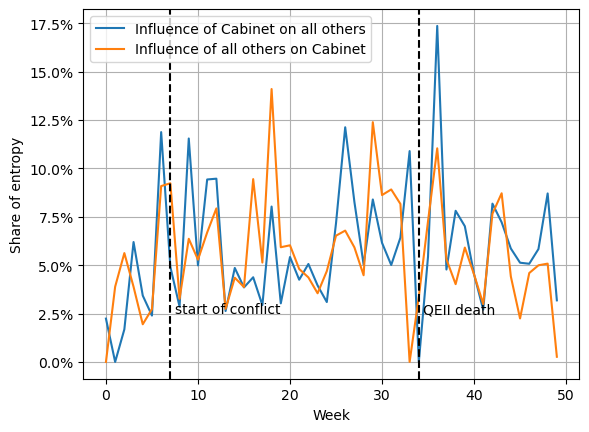

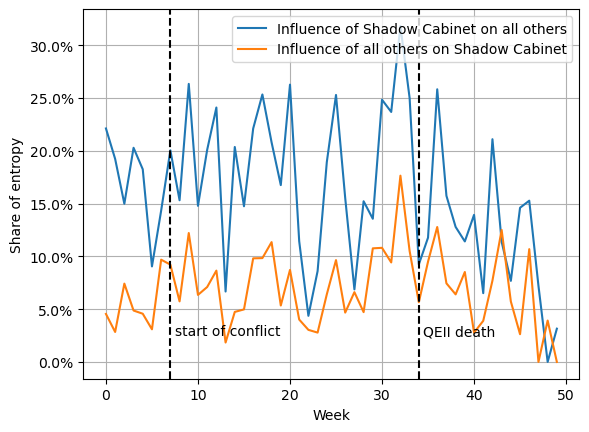

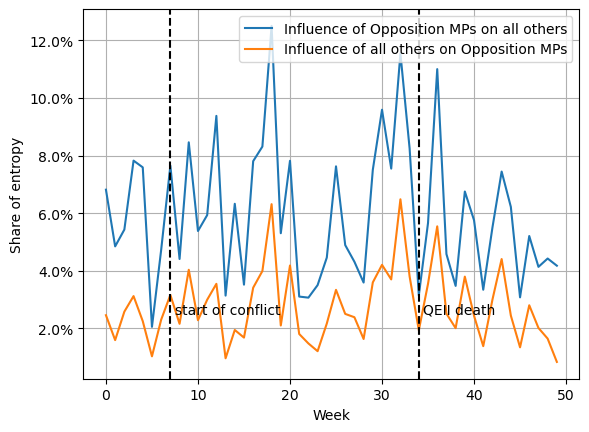

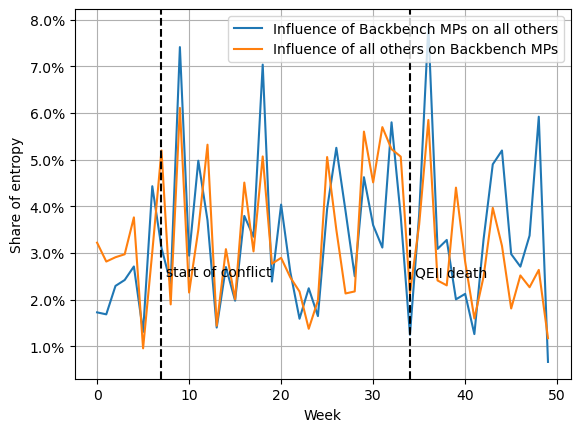

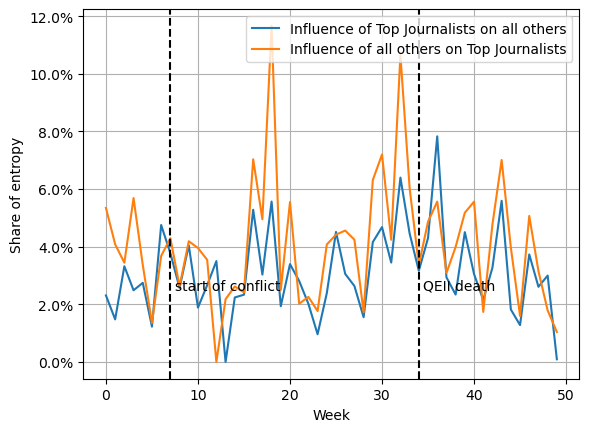

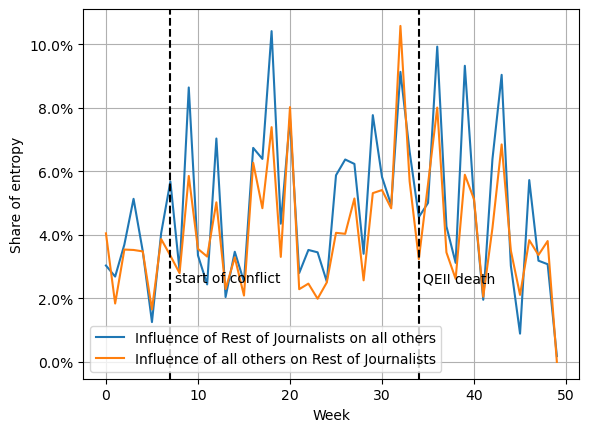

In [53]:
topic_str = 'Cost of Liging Crisis'
labels = ['Cabinet', 'Shadow Cabinet', 'Opposition MPs', 'Backbench MPs', 'Top Journalists', 'Rest of Journalists']

groups_plot = ['cabinet', 'shadow', 'opposition', 'backbench', 'rest of journalists - 2', 'top 10 journalists - 2']
for (idx, group) in enumerate(groups_plot):
    fig, ax = plt.subplots(1, 1)
    plt.plot(results_dict[topic_str][group+'_all'][:-1], label=f"Influence of {labels[idx]} on all others")
    plt.plot(results_dict[topic_str]['all_'+group][:-1], label=f"Influence of all others on {labels[idx]}")

    plt.ylabel("Share of entropy")
    plt.xlabel("Week")

    plt.axvline(x=7, color='k', linestyle="--")
    plt.axvline(x=34, color='k', linestyle="--")
    plt.annotate("start of conflict", (7.5, 2.5))
    plt.annotate("QEII death", (34.5, 2.5))
    
    plt.grid()
    plt.legend()
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    title = labels[idx].replace(" ", "_")
    #plt.savefig(f"Figures/Influence_{topic_str}-{title}.png", format='png')

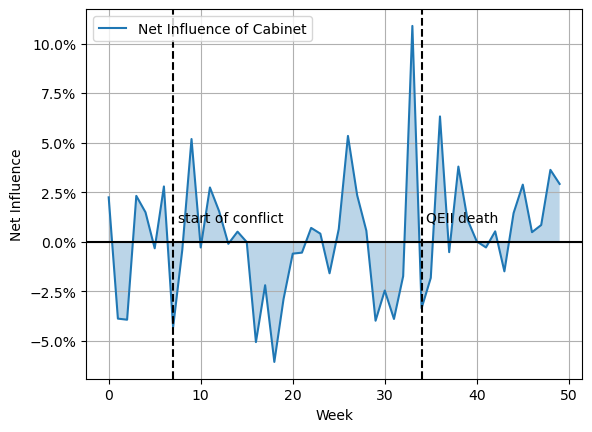

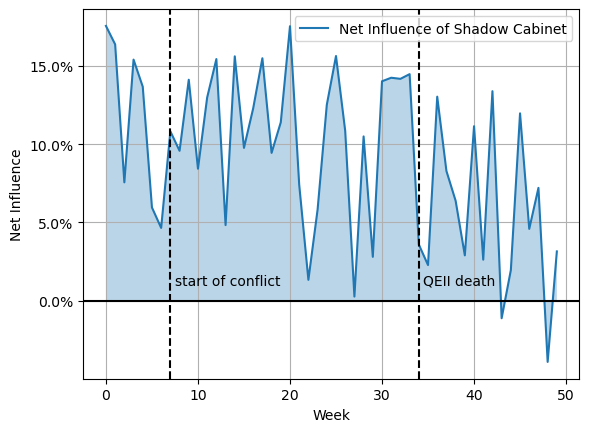

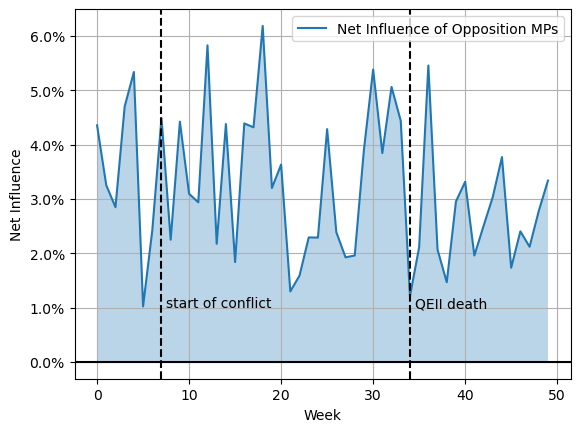

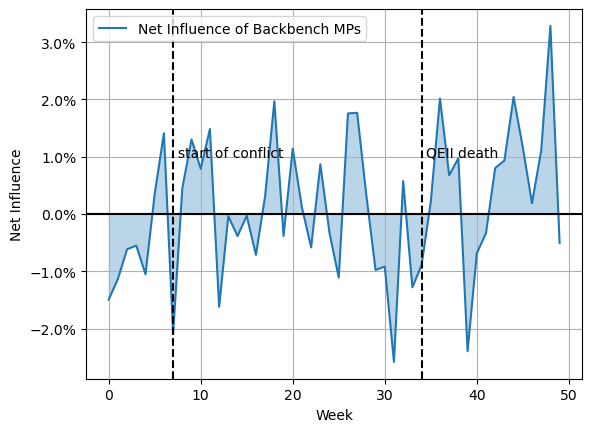

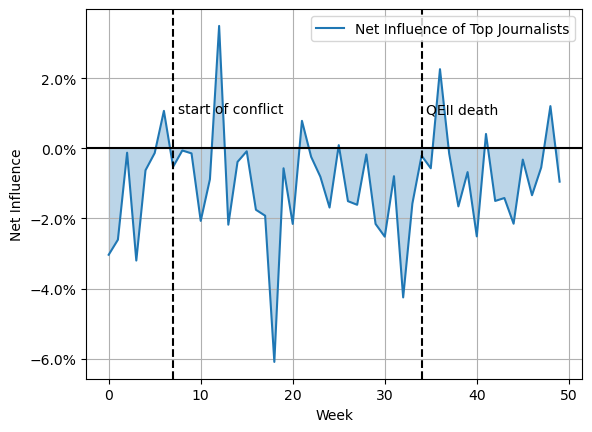

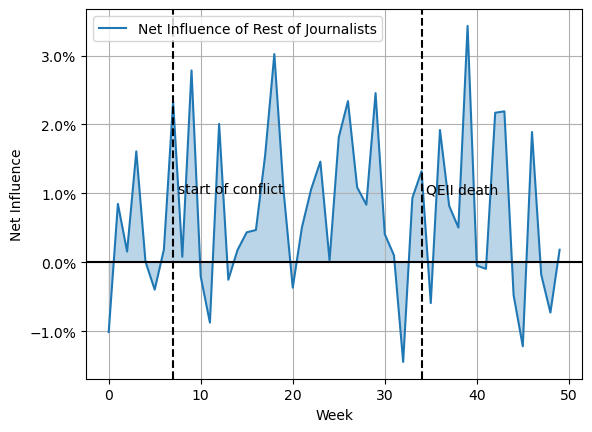

In [55]:
topic_str = 'Cost of Liging Crisis'
labels = ['Cabinet', 'Shadow Cabinet', 'Opposition MPs', 'Backbench MPs', 'Top Journalists', 'Rest of Journalists']

groups_plot = ['cabinet', 'shadow', 'opposition', 'backbench', 'rest of journalists - 2', 'top 10 journalists - 2']
for (idx, group) in enumerate(groups_plot):

    fig, ax = plt.subplots(1, 1)
    plt.plot(results_dict[topic_str][group][:-1], label=f"Net Influence of {labels[idx]}")

    plt.ylabel("Net Influence")
    plt.xlabel("Week")

    #plt.ylim(ymax=3)
    plt.axhline(y=0, color='k')

    plt.fill_between([i for i in range(50)], results_dict[topic_str][group][:-1], alpha=0.3)

    plt.axvline(x=7, color='k', linestyle="--")
    plt.axvline(x=34, color='k', linestyle="--")
    plt.annotate("start of conflict", (7.5, 1))
    plt.annotate("QEII death", (34.5, 1))

    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.grid()
    plt.legend()

    title = labels[idx].replace(" ", "_")
    #plt.savefig(f"Figures/net_influence_{topic_str}-{title}.png", format='png')